In [0]:
# The pip install can take a minute
%pip install -q urllib3<2.0 datascience ipywidgets
import pyodide_http
pyodide_http.patch_all()



<table style="width: 100%;">
    <tr style="background-color: transparent;"><td>
        <img src="https://data-88e.github.io/assets/images/blue_text.png" width="250px" style="margin-left: 0;" />
    </td><td>
        <p style="text-align: right; font-size: 10pt;"><strong>Economic Models</strong>, Fall 2022<br>
            Dr. Eric Van Dusen <br>
        Kidong Kim</p></td></tr>
</table>

# Lecture 3: Supply Demand Survey and Surplus #

The idea for this demo is to use the student's demand curve to motivate the concept of surplus.


In [1]:
!pip install oauth2client
from datascience import *
import gspread
import os
import json
from oauth2client.service_account import ServiceAccountCredentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-muted")
import matplotlib.patches as patches
%matplotlib inline

import sympy
solve = lambda x,y: sympy.solve(x-y)[0] if len(sympy.solve(x-y))==1 else "Not Single Solution"

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

Lets start off with the demand from a student survey:
 - we had 4 "goods" and a range of prices available for each good
 - students made bids on their willingness to pay for each of the 4 goods
 - the dataset for Fall 2022 has ~100 observations
 - this dataset has been exported and we read it in below:

In [30]:
# This cell loads in the data from the google form and saves it to a table called demand_table - don't worry about the code!
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_dict(json.loads(os.environ['GOOGLE_SHEETS_READONLY_KEY']), scope)
gc = gspread.authorize(creds)

url = 'https://docs.google.com/spreadsheets/d/1Izl5h_PXIph-Dk4PrsZCBWq4KQFiIoA_xh2odVo3b9A/edit?usp=sharing'#'https://docs.google.com/spreadsheets/d/16iLCfbeLQRG_GiEM5Tc0t4VYxsl9-pTIm-Kx4LaZxGI/edit?usp=sharing'

sheet = gc.open_by_url(url)
ws = sheet.worksheet('Form Responses 1')
df = pd.DataFrame(ws.get_all_records())

DemandTable = Table.from_df(df)
DemandTable = DemandTable.drop('Timestamp')
DemandTable

Masks,Burrito,GreekTix,iPhone
1,10,100,1000
0.25,5,25,1500
1,15,100,1000
1,12.5,100,1000
1,7.5,100,1250
1.5,7.5,50,1000
1.5,7.5,150,750
1,10,100,1500
0.25,5,100,1500
1.25,10,75,1250


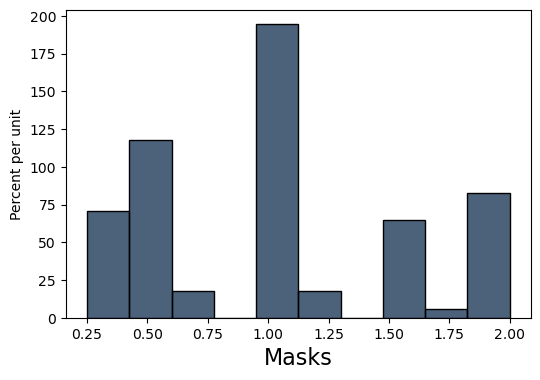

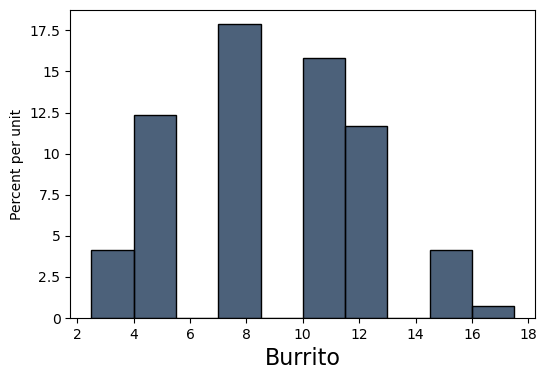

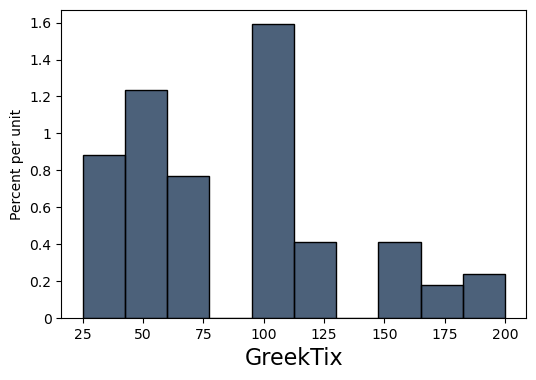

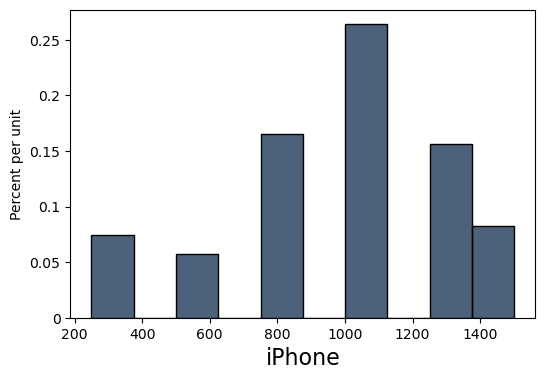

In [31]:
for i in DemandTable.labels:
    DemandTable.hist(i);

Lets focus on the burrito first. How many people are willing to buying a gourment burrito at any given price?
We can assume that a person would be willing to buy the good at a price less than their bid price.  

In [32]:
BurritosTable=DemandTable.select('Burrito')
BurritosTable

Burrito
10
5
15
12.5
7.5
7.5
7.5
10
5
10


In [33]:
# Count how many people are in each answer pool
BurritosTable.group("Burrito")

Burrito,count
2.5,6
5,18
7.5,26
10,23
12.5,17
15,6
17.5,1


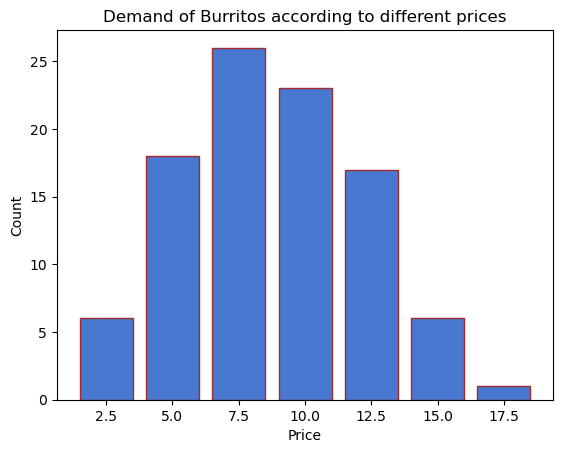

In [41]:
# Creating bar plot.
table = BurritosTable.group("Burrito")

def plot_histogram(data, bins, title="Title", x_label = "Price", y_label = "Count"):
    plt.bar(bins, data, edgecolor="brown", align="center", width = 2)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    return 

burrito_bins = table.column(0) # Select column using method call
burrito_data = table['count'] # Select column using indexing
burrito_title = "Demand of Burritos according to different prices"

plot_histogram(burrito_data, burrito_bins, burrito_title)

In the visualization above, the size of each bar isn't quite right - someone who is willing to pay $10 for a burrito will also pay $2.5 for the same burrito. Since people will pay upto their maximum bid price, let's change the visualization and table to instead consider the total demand at any given price. We can do this by:
  1) flipping the order of the count column
  2) doing a cumulative function of all prices below
  3) flipping it back

In [42]:
#Cumulative Sum of how many people are willing to pay at a agiven price
Qdemand = np.flip(np.cumsum(np.flip(BurritosTable.group("Burrito").column("count"))))

In [43]:
# Combine the two into a single table
DemandBurr= Table().with_columns([
    'priceBurr',[2.5, 5, 7.5, 10.00, 12.5, 15,17.5],
    'Qdemand',Qdemand
])
DemandBurr

priceBurr,Qdemand
2.5,97
5,91
7.5,73
10,47
12.5,24
15,7
17.5,1


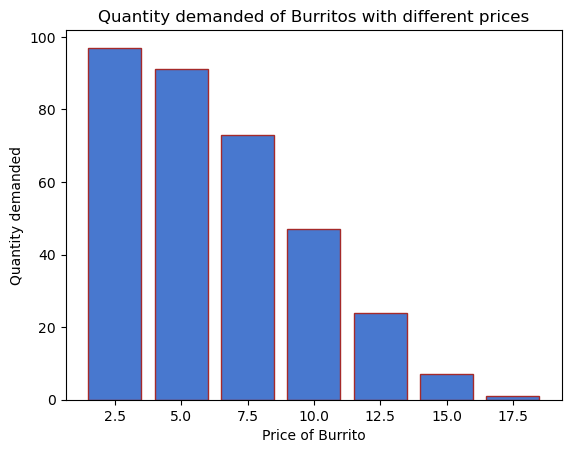

In [44]:
# Creating bar plot.
burrito_Qdemand_bins = DemandBurr.column('priceBurr') # Select column using method call
burrito_Qdemand_data = DemandBurr['Qdemand'] # Select column using indexing
burrito_Qdemand_title = "Quantity demanded of Burritos with different prices"
Qdemand_x_label = "Price of Burrito"
Qdemand_y_label = "Quantity demanded"

plot_histogram(burrito_Qdemand_data, burrito_Qdemand_bins, burrito_Qdemand_title, Qdemand_x_label, Qdemand_y_label)


## Lets take a look at this Table and think about Consumer Surplus

First, lets sort the table from the mot expensive price to the least expensive. 

Then, if the price is $10, how many people are willing to pay more than the price? These people would be getting a 'surplus' by having to pay a cheaper price than the one they would be willing to pay.


In [45]:
DemandBurr.sort("priceBurr", descending = True)

priceBurr,Qdemand
17.5,1
15,7
12.5,24
10,47
7.5,73
5,91
2.5,97


It looks like 
- 24 people would have been willing to pay up to $ 12.5

- 7 people would have been willing to pay up to $ 15.0

- 1 person would have been willing to pay up to $ 17.5

- 0 people would have been willing to pay up to $ 20.0

Lets add up these values


In [46]:
CS_counting = 24*(12.5-10)+7*(15-10)+1*(17.5-10)+0*(20-10)
print('The consumer surplus from counting consumers is ', CS_counting )

The consumer surplus from counting consumers is  102.5


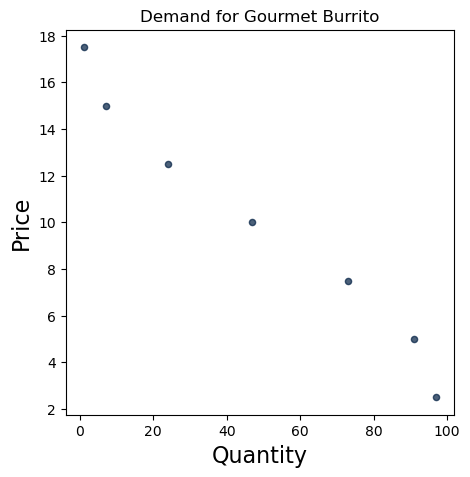

In [47]:
DemandBurr.scatter("Qdemand", "priceBurr")
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Demand for Gourmet Burrito');

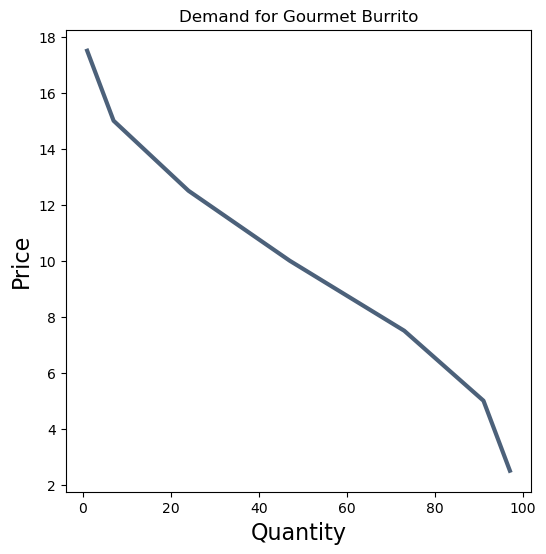

In [48]:
DemandBurr.plot("Qdemand", "priceBurr", linewidth= 3)
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Demand for Gourmet Burrito');

Now that we have a demand curve - Let's create for a model that makes a linear approximation like we did in lecture 2

In [49]:
#What are the slope and intercept of the fit line
std_units = lambda a: (a - np.mean(a)) / np.std(a)
corr = lambda x, y: np.mean(std_units(x) * std_units(y))
slope = lambda x, y: corr(x, y) * np.std(y) / np.std(x)
intercept = lambda x, y: np.mean(y) - slope(x, y) * np.mean(x)

In [50]:
burr_slope = slope(DemandBurr["Qdemand"], DemandBurr["priceBurr"])
burr_slope

-0.13517544127994124

In [51]:
burr_intercept = intercept(DemandBurr["Qdemand"], DemandBurr["priceBurr"])
burr_intercept

16.565664290740003

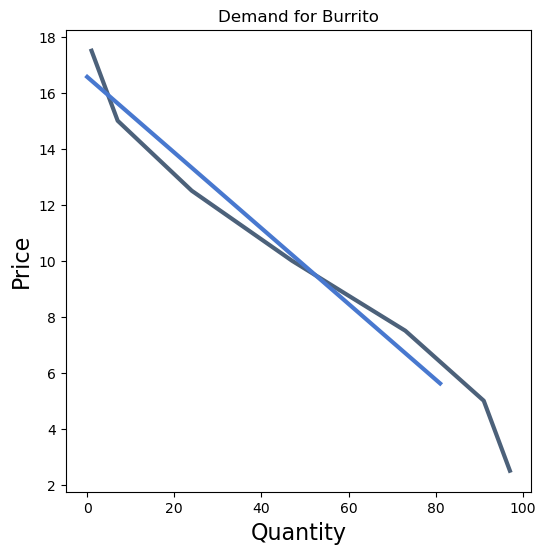

In [52]:
DemandBurr.plot("Qdemand", "priceBurr", linewidth= 3)
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Demand for Burrito');
plt.plot(np.arange(0,81,0.01), burr_slope * np.arange(0,81,0.01) + burr_intercept, linewidth= 3);

In [53]:
#How many people does the Model think would buy at $10
solve = lambda x,y: sympy.solve(x-y)[0] if len(sympy.solve(x-y))==1 else "Not Single Solution"
Q = sympy.Symbol("Q")
demand = burr_slope * Q + burr_intercept
supply = 10
Q_Star=solve(demand,supply)
Q_Star

48.5714285714286

Consumer surplus is equal to green triangle: 159.451847060829


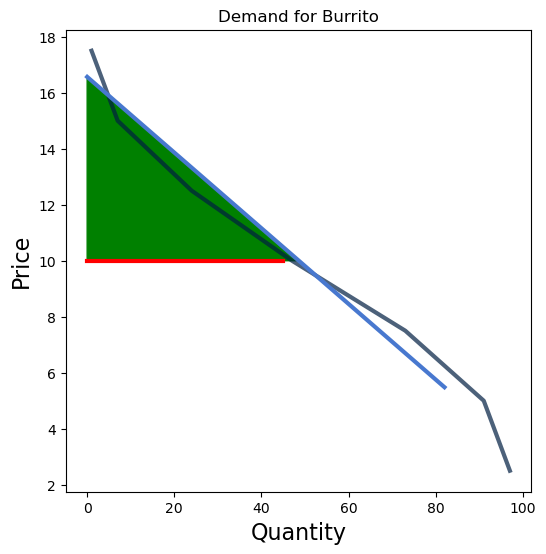

In [54]:
DemandBurr.plot("Qdemand", "priceBurr", linewidth= 3) #Black : Demand for buritto

plt.plot(np.arange(0,82,0.01), burr_slope * np.arange(0,82,0.01) + burr_intercept, linewidth= 3) #Blue : 

price = 10
plt.plot([0,45],[price, price], color = 'r', linewidth= 3) #Red : Price

triangle1 = patches.Polygon([[0,10],[Q_Star,10],[0,burr_intercept]],True,color="green") #Consumer surplus
currentAxis = plt.gca()
currentAxis.add_patch(triangle1)

plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Demand for Burrito')

burr_price = 10

# Sums up the surplus at the give price
def surplus(bins, data, price):
    #Finding the quatity at the point where red line indicating surplus and blue line indicating the relationship btw quantiy and price.
    slope_sur = slope(data, bins)
    intercept_sur = intercept(data, bins)
    Q = sympy.Symbol("Q")
    demand = slope_sur * Q + intercept_sur
    Q_Star = solve(demand, price)
    
    #Sums up the surplus and print it out.
    total_surplus = .5 * Q_Star * (intercept_sur - price)
    return total_surplus

agg_surplus = surplus(DemandBurr["priceBurr"], DemandBurr["Qdemand"], burr_price)
print("Consumer surplus is equal to green triangle: " + str(0.5 * (burr_intercept - burr_price) * Q_Star))

In [55]:
DemandBurr.sort("priceBurr", descending = True)

priceBurr,Qdemand
17.5,1
15,7
12.5,24
10,47
7.5,73
5,91
2.5,97


##  Let's try again for Greek Theater Tickets 

In [56]:
GreekTixTable=DemandTable.select('GreekTix')
GreekTixTable

GreekTix
100
25
100
100
100
50
150
100
100
75


In [57]:
Qdemand = np.flip(np.cumsum(np.flip(GreekTixTable.group("GreekTix").column("count"))))

In [58]:
DemandGreekTix= Table().with_columns([
    'priceTix',[25, 50, 75, 100, 125, 150,175, 200],
    'Qdemand',Qdemand
])
DemandGreekTix

priceTix,Qdemand
25,97
50,82
75,61
100,48
125,21
150,14
175,7
200,4


In [59]:
tix_slope = slope(DemandGreekTix["Qdemand"], DemandGreekTix["priceTix"])
tix_intercept = intercept(DemandGreekTix["Qdemand"], DemandGreekTix["priceTix"])
tix_slope, tix_intercept

(-1.6740508103864058, 182.39162133363243)

In [60]:
#How many people does the Model think would buy at $100
solve = lambda x,y: sympy.solve(x-y)[0] if len(sympy.solve(x-y))==1 else "Not Single Solution"
Q = sympy.Symbol("Q")
demand = tix_slope * Q + tix_intercept
supply = 100
Q_Star=solve(demand,supply)
Q_Star

49.2169179229479

Consumer surplus is equal to green triangle: 2027.53083235800


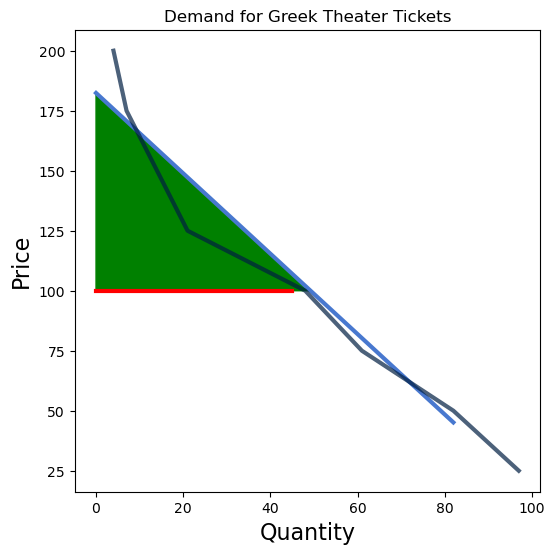

In [61]:
DemandGreekTix.plot("Qdemand", "priceTix", linewidth=3, zorder=20) #Black : Demand for Greek Theater

triangle1 = patches.Polygon([[0,100],[Q_Star,100],[0,tix_intercept]], True, color="green", zorder=1)
currentAxis = plt.gca()
currentAxis.add_patch(triangle1)

plt.plot(np.arange(0,82,0.01), tix_slope * np.arange(0,82,0.01) + tix_intercept, linewidth= 3, zorder=5) #Blue : Demand

price = 100

# This line to interactive version
plt.plot([0,45],[price]*2, color = 'r', linewidth= 3, zorder = 10) #Red : Price

plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Demand for Greek Theater Tickets');

agg_surplus = surplus(DemandGreekTix["priceTix"], DemandGreekTix["Qdemand"], price)
print("Consumer surplus is equal to green triangle: " + str(agg_surplus))

## Section 2  - fun with widgets

In [68]:
p = sympy.Symbol("p")
def Equilibrium(demandParam, supplyParam, priceStart):
    demandEquation = demandParam - p
    # change the slope
    supplyEquation = p * (supplyParam/10)
    priceEnd = sympy.solve(demandEquation)[0]
    prices = []
    demandQ = []
    supplyQ = []
    for price in range(priceStart,priceEnd+1):
        prices += [price]
        demandQ += [demandEquation.subs(p,price)]
        supplyQ += [supplyEquation.subs(p,price)]
    
    equilibriumP = sympy.solve(demandEquation-supplyEquation)[0]
    equilibriumQ = demandEquation.subs(p,equilibriumP)
    
    
    
    triangle1 = patches.Polygon([[equilibriumQ,equilibriumP],[0,equilibriumP],[0,priceEnd]],True,color="green")
    triangle2 = patches.Polygon([[equilibriumQ,equilibriumP],[0,equilibriumP],[0,0]],True,color="red")
    currentAxis = plt.gca()
    currentAxis.add_patch(triangle1)
    currentAxis.add_patch(triangle2)
    
    plt.plot(demandQ,prices)
    plt.plot(supplyQ,prices)
    plt.legend(["Demand","Supply"])
    plt.plot(equilibriumQ,equilibriumP, 'ro')
    plt.xlabel("Supply and Demand Quantity")
    plt.ylabel("Price")
    plt.ylim(0, 15)
    plt.xlim(0, 10)
    plt.show()
    print("The equilibrium price is "+str(round(equilibriumP,2))[0:4]+" and equilibrium quantity is "+str(round(equilibriumQ,2))[0:4]+".")
    print("The consumer surplus at this equilibrium "+str((priceEnd-equilibriumP)*(equilibriumQ)*.5)[0:4])
    print("The producer surplus at this equilibrium "+str((equilibriumP)*(equilibriumQ)*.5)[0:4])
# you can change the range here
slider1 = widgets.IntSlider(min=5, max=15,step=1,value=10)
slider2 = widgets.IntSlider(min=1, max=20,step=1,value=10)
slider3 = widgets.IntSlider(min=-5, max=5,step=1,value=0)
display(widgets.interactive(Equilibrium, demandParam=slider1, supplyParam=slider2, priceStart=slider3))

interactive(children=(IntSlider(value=10, description='demandParam', max=15, min=5), IntSlider(value=10, descr…

In [63]:
def eqSolve(eq1,eq2,tax):
    demandP = sympy.solve(eq1-q,p)[0]
    supplyP = sympy.solve(eq2-q,p)[0]
    demandP = demandP-cTax
    supplyP = supplyP+pTax

    demandQ = sympy.solve(demandP-p,q)[0]
    supplyQ = sympy.solve(supplyP-p,q)[0]
    
    return sympy.solve((demandP-supplyP, demandQ-supplyQ,tax-cTax-pTax), q,p,cTax,pTax)[q]

In [69]:
p = sympy.Symbol("p")
q = sympy.Symbol("q")
cTax = sympy.Symbol("cTax")
pTax = sympy.Symbol("pTax")

def EquilibriumTax(demandParam,supplyParam,priceStart,priceEnd,tax):
    demandEquation = demandParam - p
    supplyEquation = p * (supplyParam/10)
    prices = []
    demand = []
    supply = []
    for price in range(priceStart,priceEnd+1):
        prices += [price]
        demand += [demandEquation.subs(p,price)]
        supply += [supplyEquation.subs(p,price)]
        
    
    
    nonTaxPrice = sympy.solve(demandEquation-supplyEquation)[0]
    nonTaxQ = demandEquation.subs(p,nonTaxPrice)

    
    equilibriumQ = eqSolve(demandEquation,supplyEquation,tax)
    equilibriumP1 = sympy.solve(demandEquation-equilibriumQ)[0]
    equilibriumP2 = sympy.solve(supplyEquation-equilibriumQ)[0]
    
    triangle1 = patches.Polygon([[nonTaxQ,nonTaxPrice],[equilibriumQ,nonTaxPrice],[equilibriumQ,equilibriumP1]],True,color="green")
    triangle2 = patches.Polygon([[nonTaxQ,nonTaxPrice],[equilibriumQ,nonTaxPrice],[equilibriumQ,equilibriumP2]],True)
    currentAxis = plt.gca()
    currentAxis.add_patch(triangle1)
    currentAxis.add_patch(triangle2)
    
    
    rect1 = patches.Rectangle((0,nonTaxPrice),equilibriumQ,equilibriumP1-nonTaxPrice,linewidth=1,facecolor="red")
    rect2 = patches.Rectangle((0,nonTaxPrice),equilibriumQ,equilibriumP2-nonTaxPrice,linewidth=1,facecolor="yellow")
    currentAxis.add_patch(rect1)
    currentAxis.add_patch(rect2)
    
    plt.plot(demand,prices)
    plt.plot(supply,prices)
    
    
    plt.legend([rect1,rect2,triangle1,triangle2], ["Consumer Tax","Producer Tax","Consumer Deadweight Loss","Producer Deadweight Loss"])
    plt.plot(equilibriumQ,equilibriumP1, 'ro')
    plt.plot(equilibriumQ,equilibriumP2, 'ro')
    plt.xlabel("Supply and Demand Quantity")
    plt.ylabel("Price")
    plt.ylim(0, 15)
    plt.xlim(0, 10)
    plt.show()
    print("Without Tax - the equilibrium price is "+str(round(nonTaxPrice,2))[0:4]+" and equilibrium quantity is "+str(round(nonTaxQ,2))[0:4])
    print("With Tax - Price paid by consumers is "+str(equilibriumP1)[0:4]+". Price received by suppliers is "+str(round(equilibriumP2,2))[0:4]+" and the equilibrium quantity is "+str(equilibriumQ)[0:4]+".")
    print("Taxes raised from consumers equals "+str(round(equilibriumQ*(equilibriumP1-nonTaxPrice),2))[0:4])
    print("Taxes raised from producers equals "+str(round(equilibriumQ*(nonTaxPrice-equilibriumP2),2))[0:4])
    print("Total taxes raised equals "+str(equilibriumQ*tax))

slider1 = widgets.IntSlider(min=5, max=15,step=1,value=10)
slider2 = widgets.IntSlider(min=1, max=20,step=1,value=10)
slider3 = widgets.IntSlider(min=-5, max=5,step=1,value=0)
slider4 = widgets.IntSlider(min=5, max=20,step=1,value=10)
slider5 = widgets.IntSlider(min=0, max=8,step=1,value=4)
display(widgets.interactive(EquilibriumTax, demandParam=slider1, supplyParam=slider2, priceStart=slider3, priceEnd=slider4, tax=slider5))

interactive(children=(IntSlider(value=10, description='demandParam', max=15, min=5), IntSlider(value=10, descr…